# First Approach - XGRegressor

17/11/2025

## Import Modules

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import sklearn
import xgboost

## Import Data

In [2]:
data = pd.read_csv("data_20251117.csv", sep=";")

data.head(5)

,Classe,Nom,MS % brut,PB % brut,CB % brut,MGR % brut,MM % brut,NDF % brut,ADF % brut,Lignine % brut,...,Sucres % brut,EB (kcal) kcal/kg brut,ED porc croissance (kcal) kcal/kg brut,EM porc croissance (kcal) kcal/kg brut,EN porc croissance (kcal) kcal/kg brut,EMAn coq (kcal) kcal/kg brut,EMAn poulet (kcal) kcal/kg brut,UFL 2018 par kg brut,PDI 2018 g/kg brut,BalProRu 2018 g/kg brut
0,Céréales,Blé,90.800003,8.0,2.0,1.2,1.3,11.4,2.8,0.9,...,2.6,3900,3470,3380,2660,3060,2940,1.09,74,-40.0
1,Céréales,Blé,90.000000,8.0,1.9,1.2,1.4,11.0,2.7,0.9,...,2.6,3860,3450,3360,2640,3040,2920,1.08,73,-39.0
2,Céréales,Blé,89.000000,8.0,1.9,1.2,1.4,10.9,2.7,0.9,...,2.6,3820,3410,3320,2610,2980,2870,1.07,73,-38.0
3,Céréales,Blé,88.800003,8.0,1.9,1.2,1.4,10.9,2.7,0.9,...,2.6,3810,3400,3310,2600,2980,2860,1.07,73,-37.0
4,Céréales,Blé,88.500000,8.0,2.3,1.2,1.6,12.5,3.2,1.0,...,2.6,3790,3320,3230,2550,3000,2880,1.05,72,-36.0


In [3]:
colonnes = data.columns

colonnes_X = list(colonnes[:12])
colonne_Y_empc = [colonnes[15]]
colonne_Y_edpc = [colonnes[14]]
colonne_Y_enpc = [colonnes[16]]
colonne_Y_emcq = [colonnes[17]]
colonne_Y_emplt = [colonnes[18]]


print(colonnes_X)
print(colonne_Y_empc)

colonnes_cat = colonnes_X[:2]
colonnes_num = colonnes_X[2:]

['Classe', 'Nom', 'MS % brut', 'PB % brut', 'CB % brut', 'MGR % brut', 'MM % brut', 'NDF % brut', 'ADF % brut', 'Lignine % brut', 'Amidon % brut', 'Sucres % brut']
['EN porc croissance (kcal) kcal/kg brut']


In [4]:
X = data[colonnes_X].values
y_empc = data[colonne_Y_empc].values
y_edpc = data[colonne_Y_edpc].values
y_enpc = data[colonne_Y_enpc].values
y_emcq = data[colonne_Y_emcq].values
y_emplt = data[colonne_Y_emplt].values


X_cat = data[colonnes_cat].values
X_num = data[colonnes_num].values

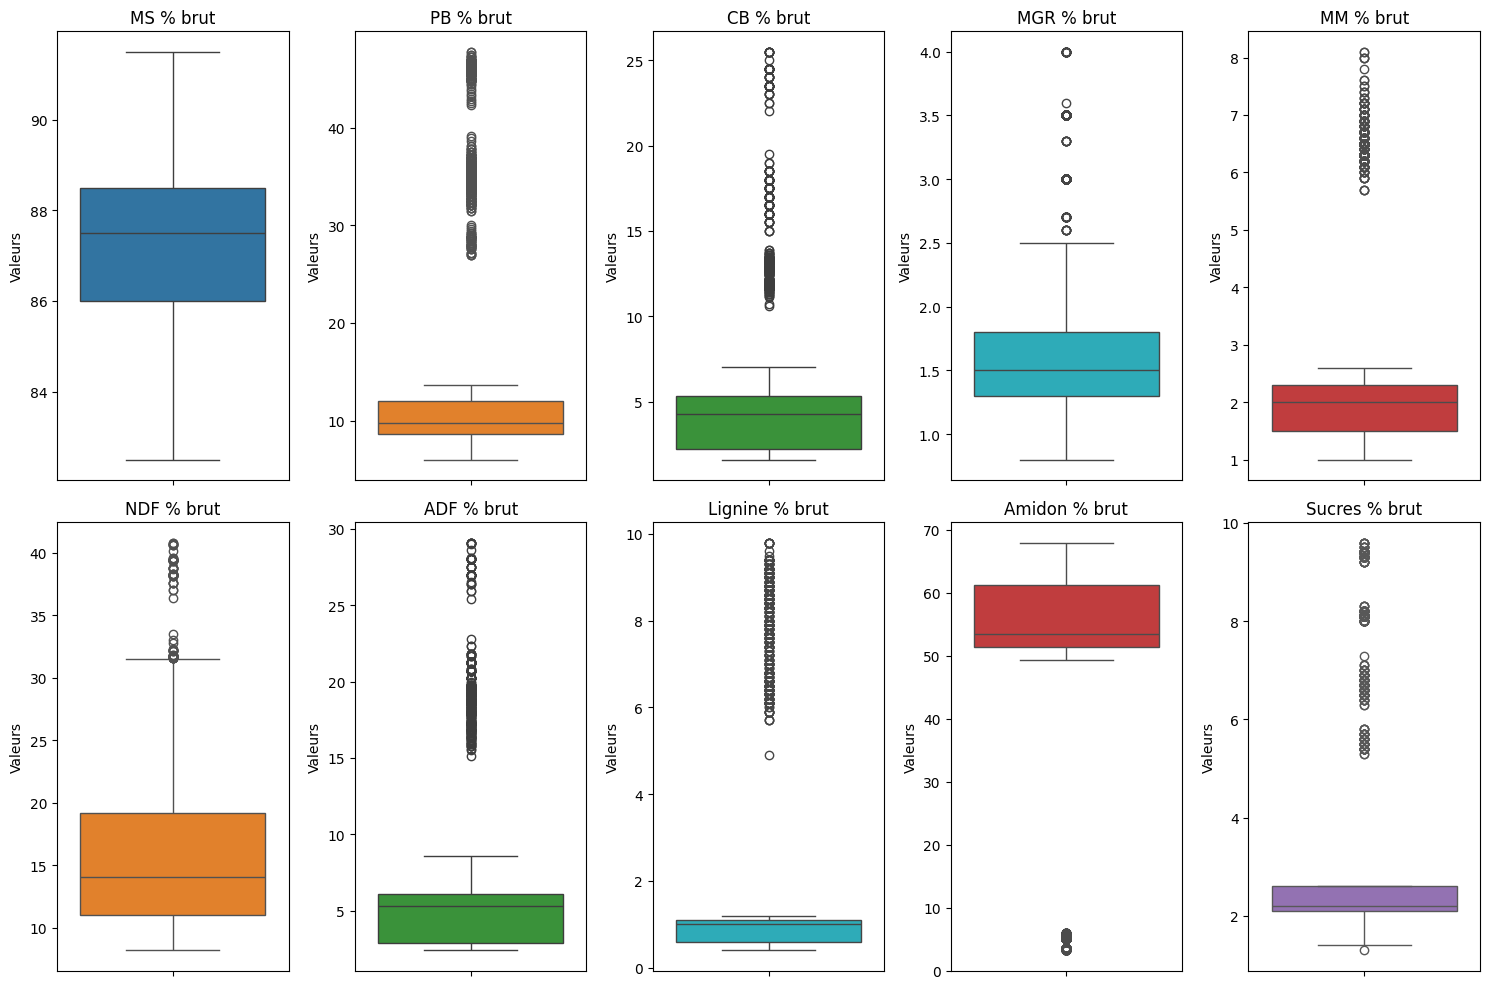

In [5]:
import seaborn as sns

fig, axes = plt.subplots(2, 5, figsize=(15, 10))

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:cyan', 'tab:red', 'tab:purple']
num_col = 0

for k in range(2):
    for l in range(5):
        
        ax = axes[k,l]
        color = colors[l+k]
        array = X_num[:, num_col]

        sns.boxplot(y=array, ax=ax, color=color)
        ax.set_xlabel("")  # pas pertinent ici
        ax.set_ylabel("Valeurs")
        ax.set_title(colonnes_num[num_col])
        ax.tick_params(axis='x', labelbottom=False)  # Pas de labels x
        num_col +=1
plt.tight_layout()
plt.show()

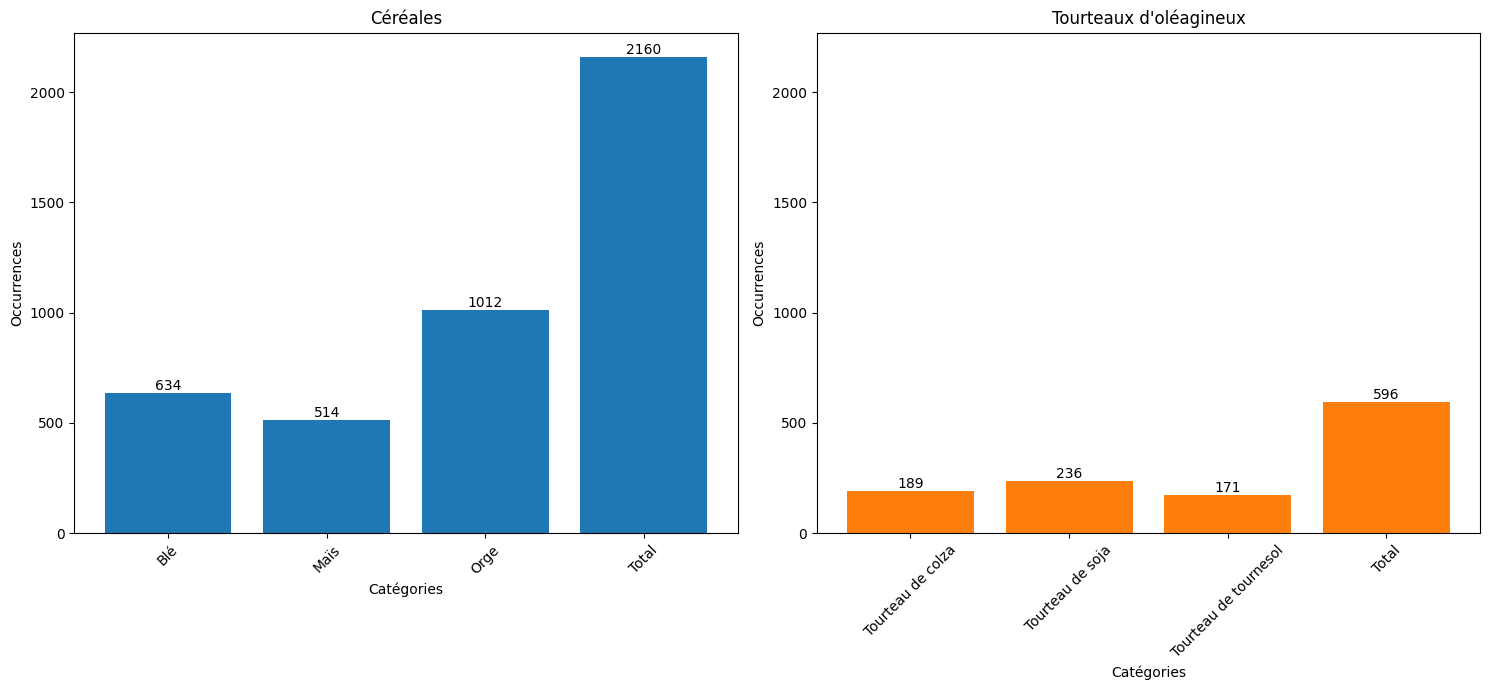

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
colors = ['tab:blue', 'tab:orange', 'tab:green']
unique_classe, counts_classe = np.unique(X_cat[:,0], return_counts=True)
unique_nom, counts_nom = np.unique(X_cat[:,1], return_counts=True)
ylim = int(max(counts_classe)*1.05)

for k in range(2):
    ax = axes[k]
    color = colors[k]

    index = np.where(X_cat[:,0] == unique_classe[k])[0]
    array = X_cat[index, 1]
    unique, counts = np.unique(array, return_counts=True)

    # Ajout du total
    unique = np.concatenate([unique, np.array(["Total"])])
    counts = np.concatenate([counts, np.array([counts_classe[k]])])

    ax.bar(unique, counts, color=color)
    ax.set_ylim(0, ylim + 1)
    ax.set_xlabel("Catégories")
    ax.set_ylabel("Occurrences")
    ax.set_title(unique_classe[k])
    ax.tick_params(axis='x', rotation=45)

    # === Ajout des valeurs au-dessus de chaque barre ===
    for i, val in enumerate(counts):
        ax.text(i, val + 0.1, str(val), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


## One Hot encoding des variables catégorielles

In [7]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)

stockage = np.zeros((X_cat.shape[0],1))

for k in range(X_cat.shape[1]):
    encoded = encoder.fit_transform(X_cat[:,k].reshape(-1,1))
    stockage = np.concatenate((stockage,encoded), axis=1)

X_encoded = stockage[:,1:]
colonnes_encoded = list(unique_classe)+list(unique_nom)

print(X_encoded[:10])
print(colonnes_encoded)

[[1. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0.]]
['Céréales', "Tourteaux d'oléagineux", 'Blé', 'Maïs', 'Orge', 'Tourteau de colza', 'Tourteau de soja', 'Tourteau de tournesol']


In [8]:
X_tot_enc = np.concatenate((X_encoded, X_num), axis=1)
colonnes_tot_enc = colonnes_encoded+colonnes_num

print(colonnes_tot_enc)
print(X_tot_enc[:2])

['Céréales', "Tourteaux d'oléagineux", 'Blé', 'Maïs', 'Orge', 'Tourteau de colza', 'Tourteau de soja', 'Tourteau de tournesol', 'MS % brut', 'PB % brut', 'CB % brut', 'MGR % brut', 'MM % brut', 'NDF % brut', 'ADF % brut', 'Lignine % brut', 'Amidon % brut', 'Sucres % brut']
[[ 1.          0.          1.          0.          0.          0.
   0.          0.         90.80000305  8.          2.          1.20000005
   1.29999995 11.39999962  2.79999995  0.89999998 65.09999847  2.5999999 ]
 [ 1.          0.          1.          0.          0.          0.
   0.          0.         90.          8.          1.89999998  1.20000005
   1.39999998 11.          2.70000005  0.89999998 64.69999695  2.5999999 ]]


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test,\
    y_train_empc, y_test_empc,\
    y_train_edpc, y_test_edpc,\
    y_train_enpc, y_test_enpc,\
    y_train_emcq, y_test_emcq,\
    y_train_emplt, y_test_emplt\
          = train_test_split(X_tot_enc, y_empc, y_edpc, y_enpc, y_emcq, y_emplt, test_size=0.3)

print(X_train.shape)
print(X_test.shape)

(1929, 18)
(827, 18)


In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluation_regression(model, X_train, X_test, y_train, y_test, model_name = ""):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print("")
    print(f'Essai sur échantillon de test {model_name}')
    print("y_pred min/max :", round(y_pred.min(),3), round(y_pred.max(),3))
    print(f"MAE: {mae:.3f} | RMSE: {rmse:.3f} | R²: {r2:.3f}")
    return [model_name,mae,rmse,r2]

In [11]:
df = pd.DataFrame(columns=["Model_name","MAE", "RMSE", "R2"])

In [12]:
from xgboost import XGBRegressor

# XGBRegressor
model_xgb_empc = XGBRegressor()
df.loc[len(df)] =evaluation_regression(model_xgb_empc, X_train, X_test, y_train_empc, y_test_empc,"XGBRegressor_empc")

model_xgb_edpc = XGBRegressor()
df.loc[len(df)] =evaluation_regression(model_xgb_edpc, X_train, X_test, y_train_edpc, y_test_edpc,"XGBRegressor_edpc")

model_xgb_enpc = XGBRegressor()
df.loc[len(df)] =evaluation_regression(model_xgb_enpc, X_train, X_test, y_train_enpc, y_test_enpc,"XGBRegressor_enpc")

model_xgb_emcq = XGBRegressor()
df.loc[len(df)] = evaluation_regression(model_xgb_emcq, X_train, X_test, y_train_emcq, y_test_emcq,"XGBRegressor_emcq")

model_xgb_emplt = XGBRegressor()
df.loc[len(df)] = evaluation_regression(model_xgb_emplt, X_train, X_test, y_train_emplt, y_test_emplt,"XGBRegressor_emplt")


Essai sur échantillon de test XGBRegressor_empc
y_pred min/max : 1090.423 2761.09
MAE: 5.745 | RMSE: 11.282 | R²: 0.999

Essai sur échantillon de test XGBRegressor_edpc
y_pred min/max : 1917.188 3442.176
MAE: 6.256 | RMSE: 9.665 | R²: 0.999

Essai sur échantillon de test XGBRegressor_enpc
y_pred min/max : 1301.465 3297.688
MAE: 6.535 | RMSE: 20.150 | R²: 0.998

Essai sur échantillon de test XGBRegressor_emcq
y_pred min/max : 1289.596 3224.971
MAE: 7.102 | RMSE: 32.404 | R²: 0.996

Essai sur échantillon de test XGBRegressor_emplt
y_pred min/max : 0.607 1.161
MAE: 0.003 | RMSE: 0.004 | R²: 0.998


In [13]:
print(df)

           Model_name       MAE       RMSE        R2
0   XGBRegressor_empc  5.745152  11.281985  0.998994
1   XGBRegressor_edpc  6.255791   9.665036  0.998703
2   XGBRegressor_enpc  6.535465  20.149934  0.998311
3   XGBRegressor_emcq  7.101711  32.403673  0.995665
4  XGBRegressor_emplt  0.003359   0.004286  0.998173


In [15]:
print(colonnes_tot_enc)
print(X_tot_enc[:2])


['Céréales', "Tourteaux d'oléagineux", 'Blé', 'Maïs', 'Orge', 'Tourteau de colza', 'Tourteau de soja', 'Tourteau de tournesol', 'MS % brut', 'PB % brut', 'CB % brut', 'MGR % brut', 'MM % brut', 'NDF % brut', 'ADF % brut', 'Lignine % brut', 'Amidon % brut', 'Sucres % brut']
[[ 1.          0.          1.          0.          0.          0.
   0.          0.         90.80000305  8.          2.          1.20000005
   1.29999995 11.39999962  2.79999995  0.89999998 65.09999847  2.5999999 ]
 [ 1.          0.          1.          0.          0.          0.
   0.          0.         90.          8.          1.89999998  1.20000005
   1.39999998 11.          2.70000005  0.89999998 64.69999695  2.5999999 ]]


In [21]:
X_train1= X_tot_enc[np.where(X_tot_enc[:,0] ==1)[0]]
X_test1= X_tot_enc[np.where(X_tot_enc[:,0] ==0)[0]]
y_train_empc1 = y_empc[np.where(X_tot_enc[:,0] ==1)[0]]
y_test_empc1 = y_empc[np.where(X_tot_enc[:,0] ==0)[0]]
y_train_edpc1 = y_edpc[np.where(X_tot_enc[:,0] ==1)[0]]
y_test_edpc1 = y_edpc[np.where(X_tot_enc[:,0] ==0)[0]]
y_train_enpc1 = y_enpc[np.where(X_tot_enc[:,0] ==1)[0]]
y_test_enpc1 = y_enpc[np.where(X_tot_enc[:,0] ==0)[0]]
y_train_emcq1 = y_emcq[np.where(X_tot_enc[:,0] ==1)[0]]
y_test_emcq1 = y_empc[np.where(X_tot_enc[:,0] ==0)[0]]
y_train_emplt1 = y_emplt[np.where(X_tot_enc[:,0] ==1)[0]]
y_test_emplt1 = y_emplt[np.where(X_tot_enc[:,0] ==0)[0]]

In [22]:
# XGBRegressor
model_xgb_empc = XGBRegressor()
df.loc[len(df)] =evaluation_regression(model_xgb_empc, X_train1, X_test1, y_train_empc1, y_test_empc1,"XGBRegressor_empc")

model_xgb_edpc = XGBRegressor()
df.loc[len(df)] =evaluation_regression(model_xgb_edpc, X_train1, X_test1, y_train_edpc1, y_test_edpc1,"XGBRegressor_edpc")

model_xgb_enpc = XGBRegressor()
df.loc[len(df)] =evaluation_regression(model_xgb_enpc, X_train1, X_test1, y_train_enpc1, y_test_enpc1,"XGBRegressor_enpc")

model_xgb_emcq = XGBRegressor()
df.loc[len(df)] = evaluation_regression(model_xgb_emcq, X_train1, X_test1, y_train_emcq1, y_test_emcq1,"XGBRegressor_emcq")

model_xgb_emplt = XGBRegressor()
df.loc[len(df)] = evaluation_regression(model_xgb_emplt, X_train1, X_test1, y_train_emplt1, y_test_emplt1,"XGBRegressor_emplt")


Essai sur échantillon de test XGBRegressor_empc
y_pred min/max : 2174.005 2395.226
MAE: 567.827 | RMSE: 631.149 | R²: -3.809

Essai sur échantillon de test XGBRegressor_edpc
y_pred min/max : 2857.758 3192.186
MAE: 385.773 | RMSE: 438.873 | R²: -0.075

Essai sur échantillon de test XGBRegressor_enpc
y_pred min/max : 2779.963 2888.994
MAE: 982.369 | RMSE: 1060.494 | R²: -6.138

Essai sur échantillon de test XGBRegressor_emcq
y_pred min/max : 2647.033 2746.852
MAE: 1019.961 | RMSE: 1058.283 | R²: -12.522

Essai sur échantillon de test XGBRegressor_emplt
y_pred min/max : 0.94 1.036
MAE: 0.150 | RMSE: 0.165 | R²: 0.006
